# PCアルゴリズム

Peter-Clark (PC) algorithm

**Step1：すべてのノード間が無向のエッジで結ばれたグラフを作る**

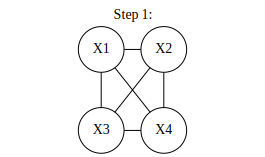

In [9]:
import graphviz

graphviz.Source("""
graph step1 {
  rankdir=TB;
  node [shape=circle, fontsize=14];

  X1 -- X2;
  X1 -- X3;
  X1 -- X4;
  X2 -- X3;
  X2 -- X4;
  X3 -- X4;

  label="Step 1: 初期状態（完全無向グラフ）";
  labelloc="t";
  
  { rank = same; X1; X2; }
  { rank = same; X3; X4; }
}
""")

**Step 2：条件付き独立性を検定し、不要なエッジの削除**

独立性や条件付き独立性をカイ二乗検定で判定していく。 $X_i \perp X_j$ または $X_i \perp X_j \mid S$ が統計的に判定できた場合、そのエッジを削除し、分離集合（separating set）$S$ を記録する。

例：$X_1 \perp X_3 \mid X_2$ が成立 → 辺 X1–X3 を削除、sep(X1,X3) = {X2}

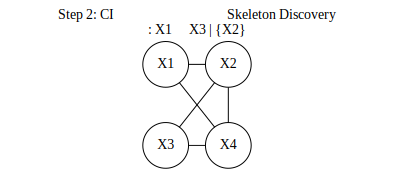

In [10]:
import graphviz

graphviz.Source("""
graph step2 {
  rankdir=TB;
  node [shape=circle, fontsize=14];

  // Edges after removal of X1--X3
  X1 -- X2;
  X1 -- X4;
  X2 -- X3;
  X2 -- X4;
  X3 -- X4;

  label="Step 2: CI に基づくエッジ削除（Skeleton Discovery）\n例: X1 ⟂ X3 | {X2}";
  labelloc="t";
  
  { rank = same; X1; X2; }
  { rank = same; X3; X4; }
}
""")

**Step 3：V－構造（Collider）の同定**

3変数 $X_i - X_j - X_k$ のパターンで、

- $X_i$ と $X_k$ が「隣接していない」（エッジがない、$X_i \perp X_k \mid S$）
- その分離集合 sep($X_i, X_k$) に $X_j$ が含まれない（$X_j \notin S$）

のとき、$X_i \rightarrow X_j \leftarrow X_k$（V構造、collider） と向きを付ける。


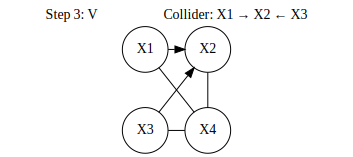

In [12]:
import graphviz

graphviz.Source("""
digraph step3 {
  rankdir=TB;
  node [shape=circle, fontsize=14];

  X1 -> X2;
  X3 -> X2;

  // Keep the remaining undirected edges
  X1 -> X4 [dir=none];
  X2 -> X4 [dir=none];
  X3 -> X4 [dir=none];

  label="Step 3: V構造の同定（Collider: X1 → X2 ← X3）";
  labelloc="t";

  { rank = same; X1; X2; }
  { rank = same; X3; X4; }
}
""")

**Step 4：向き付け規則（Orientation Rules）で残りの辺を決める**

追加のルールを適用し、サイクルを作らない・新たな collider を作らないように残りの無向辺に向きを付ける。

代表的ルール：
- Orientation propagation：$X \to Y - Z$ なら $Y \to Z$
- Acyclicity constraint（サイクル禁止）
- Avoid new colliders（既存以外の新規 collider を作らない）


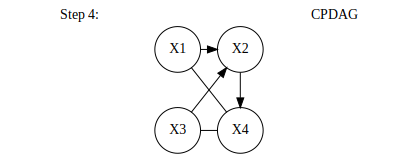

In [13]:
import graphviz

graphviz.Source("""
digraph step3 {
  rankdir=TB;
  node [shape=circle, fontsize=14];

  X1 -> X2;
  X3 -> X2;
  X2 -> X4;
  X1 -> X4 [dir=none];
  X3 -> X4 [dir=none];

  label="Step 4: 向き付け規則により部分的に方向が決定（CPDAG）";
  labelloc="t";

  { rank = same; X1; X2; }
  { rank = same; X3; X4; }
}
""")

## 限界・注意点

PCアルゴリズムは以下の点に注意が必要

**1️⃣すべての変数間の因果の方向が定まらないことがある**

同じ条件付き独立性を与える因果グラフの集合を **マルコフ同値類（Markov equivalence class: MEC）** という。  
PCアルゴリズムではMECの中から因果グラフを一意に特定できない場合がある。

**2️⃣サンプルサイズが必要**

サンプルサイズが小さい場合はカイ二乗分布を用いた近似精度が悪化するため、適切に検定できなくなる

**3️⃣高次元データに弱い**

PCアルゴリズムは条件付き独立性の検定を実施する順番に影響されやすい。そのため次元数が多いと推定が不安定になりやすい。
これを改善したPC-stableというアルゴリズムもある。

**4️⃣未観測の交絡因子と選択バイアスが考慮されていない**

因果的十分性の仮定をおいているため、この仮定が満たされない場合は因果探索の推定精度が下がる。  
この点を改良したFCIアルゴリズムが提案されている。

**5️⃣検定の有意水準の設定によって推定結果が変わる**

**6️⃣計算量が多い**

すべての変数の組み合わせに対して統計的検定を行うため、変数の数が多いと処理しきれない

## 実装

INFO:root:Finished synthetic dataset


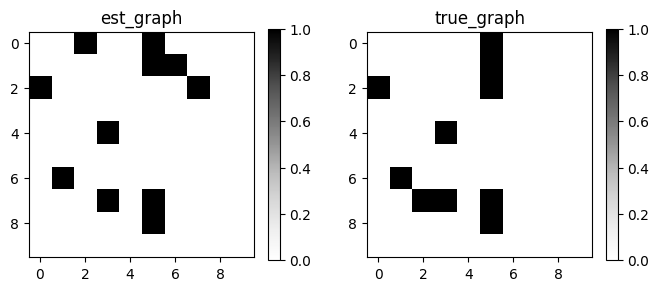

{'fdr': 0.0909, 'tpr': 1.0, 'fpr': 0.0286, 'shd': 2, 'nnz': 11, 'precision': 0.7273, 'recall': 0.8, 'F1': 0.7619, 'gscore': 0.5}


In [28]:
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import IIDSimulation, DAG
from castle.algorithms import PC

# シミュレーションデータの生成
weighted_random_dag = DAG.erdos_renyi(n_nodes=10, n_edges=10,
                                      weight_range=(0.5, 2.0), seed=1)
dataset = IIDSimulation(W=weighted_random_dag, n=2000, method='linear',
                        sem_type='gauss')
true_causal_matrix, X = dataset.B, dataset.X

# structure learning
pc = PC()
pc.learn(X)

# DAGをmatrixとしてplot
GraphDAG(pc.causal_matrix, true_causal_matrix)

# metricsを計算
mt = MetricsDAG(pc.causal_matrix, true_causal_matrix)
print(mt.metrics)

## 実装

[pgmpy](https://pgmpy.org/structure_estimator/pc.html)パッケージ

```python
# データセットの生成
import numpy as np
from pgmpy.utils import get_example_model
np.random.seed(42)
model = get_example_model("asia")
model.seed = 42
df = model.simulate(int(1e3))

# 因果構造を推定
from pgmpy.estimators import PC
dag = PC(data=df).estimate(ci_test='chi_square', return_type='dag')

# daftパッケージで作図
dag.to_daft().render()
```


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'asia': 'C', 'lung': 'C', 'xray': 'C', 'bronc': 'C', 'smoke': 'C', 'tub': 'C', 'dysp': 'C', 'either': 'C'}


  0%|          | 0/5 [00:00<?, ?it/s]

<Axes: >

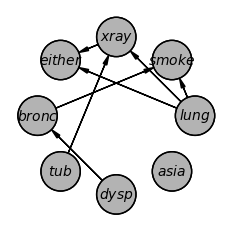

In [24]:
# データセットの生成
import numpy as np
from pgmpy.utils import get_example_model
np.random.seed(42)
model = get_example_model("asia")
model.seed = 42
df = model.simulate(int(1e3))

# 因果構造を推定
from pgmpy.estimators import PC
dag = PC(data=df).estimate(ci_test='chi_square', return_type='dag')

# daftパッケージで作図
dag.to_daft().render()

## 参考

- [[2303.15027] A Survey on Causal Discovery Methods for I.I.D. and Time Series Data](https://arxiv.org/abs/2303.15027)
